In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel, WeightedDegree_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
import pickle

with open('repeated_kfold_wd_shift_logTrue.pickle', 'rb') as handle:
    result_pkl = pickle.load(handle)

In [3]:
import xarray
result_test_s0_aveSplit_aveRepeat = result_pkl[0].loc[dict(s = 2)].mean(axis = -1).mean(axis = -1)

In [4]:
result_test_s0_aveSplit_aveRepeat

<xarray.DataArray (alpha: 21, l: 4)>
array([[0.1129239 , 0.0626964 , 0.03906395, 0.02650037],
       [0.35831672, 0.30351012, 0.26610689, 0.23580156],
       [0.43529024, 0.39558955, 0.36231926, 0.33659838],
       [0.48083834, 0.44613934, 0.41673046, 0.39352224],
       [0.51054894, 0.48067174, 0.4543802 , 0.43365248],
       [0.53409035, 0.50517861, 0.48193564, 0.46149447],
       [0.55114659, 0.52644544, 0.50441443, 0.48689648],
       [0.56795208, 0.54267927, 0.52193469, 0.50550606],
       [0.57827969, 0.55684643, 0.53813941, 0.52359403],
       [0.58961886, 0.56842537, 0.55134305, 0.53604211],
       [0.59962296, 0.57857156, 0.56288685, 0.54782188],
       [0.60867072, 0.58841316, 0.57384298, 0.56051278],
       [0.61441788, 0.59831586, 0.58123077, 0.56957114],
       [0.62145889, 0.60521185, 0.59153593, 0.57714737],
       [0.62764856, 0.61101661, 0.59705543, 0.58541856],
       [0.63408997, 0.61775587, 0.60504028, 0.59341506],
       [0.63872866, 0.62542091, 0.61126599, 0.6015262 ],
       [0.64311278, 0.62909261, 0.61765266, 0.6069378 ],
       [0.6484569 , 0.63403984, 0.6224217 , 0.61309508],
       [0.65259681, 0.63995477, 0.62666418, 0.61858657],
       [0.65709649, 0.64327888, 0.63278882, 0.62264891]])
Coordinates:
    train_test  <U5 'Train'
  * alpha       (alpha) int64 1 10 20 30 40 50 60 ... 150 160 170 180 190 200
  * l           (l) <U3 '[3]' '[4]' '[5]' '[6]'
    s           int64 2

In [5]:
result_test_s0_aveSplit_aveRepeat.coords['l'] = [3,4,5,6]

In [6]:
result_smaller_than_one = result_test_s0_aveSplit_aveRepeat.where(result_test_s0_aveSplit_aveRepeat < 1)

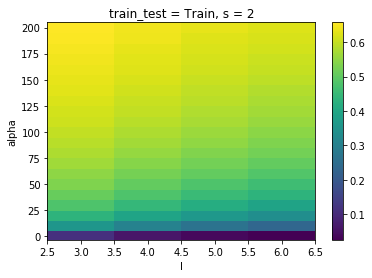

In [7]:
result_smaller_than_one.plot()

In [8]:
result_pkl[1].loc[dict(s = 1)].loc[dict(l = '[6]')].mean(axis = -1).std(axis = -1)

<xarray.DataArray (alpha: 21)>
array([0.0858109 , 0.03028038, 0.03866063, 0.02984469, 0.02412351,
       0.02400708, 0.02703176, 0.02027484, 0.01910102, 0.01614534,
       0.01193811, 0.01192419, 0.0162381 , 0.01554997, 0.01636625,
       0.01511082, 0.015718  , 0.00810333, 0.0085571 , 0.01236101,
       0.00985035])
Coordinates:
    train_test  <U5 'Test'
  * alpha       (alpha) int64 1 10 20 30 40 50 60 ... 150 160 170 180 190 200
    l           <U3 '[6]'
    s           int64 1

In [ ]:
## Plot for regress

In [10]:
Path = '../../data/firstRound_4h_normTrue_formatSeq_logTrue.csv'

df = pd.read_csv(Path)
df.head(20)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.572497,NaN,2.001765,2.026102,1.866788,0.255154
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.181122,NaN,1.309597,1.693182,1.394633,0.266411
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,NaN,0.700778,NaN,0.331062,0.493596,0.508479,0.185307
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,NaN,1.287142,NaN,1.156889,1.356925,1.266986,0.101530
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,NaN,1.379619,NaN,1.406433,1.374056,1.386702,0.017312
5,5,RBS_1by1_5,bps_noncore,TGTAAGAAGGAGATATACAT,AGGAGA,NaN,0.304483,NaN,0.070532,0.245348,0.206788,0.121649
6,6,RBS_1by1_6,bps_noncore,TATAAGAAGGAGATATACAT,AGGAGA,NaN,1.000331,NaN,0.682767,1.019584,0.900894,0.189149
7,8,RBS_1by1_8,bps_noncore,TTGAAGAAGGAGATATACAT,AGGAGA,NaN,1.185658,NaN,1.442020,1.386894,1.338191,0.134942
8,9,RBS_1by1_9,bps_noncore,TTAAAGAAGGAGATATACAT,AGGAGA,NaN,0.614593,NaN,0.304789,0.313356,0.410912,0.176444
9,10,RBS_1by1_10,bps_noncore,TTTCAGAAGGAGATATACAT,AGGAGA,NaN,0.803114,NaN,1.137199,1.009548,0.983287,0.168584


In [ ]:
kernel = 'WD_Kernel_Shift'
embedding = 'label'
eva_metric = mean_squared_error

gpr = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
                   l_list = [6], s = 2, alpha = 200)
gpr.regression()
gpr.scatter_plot()